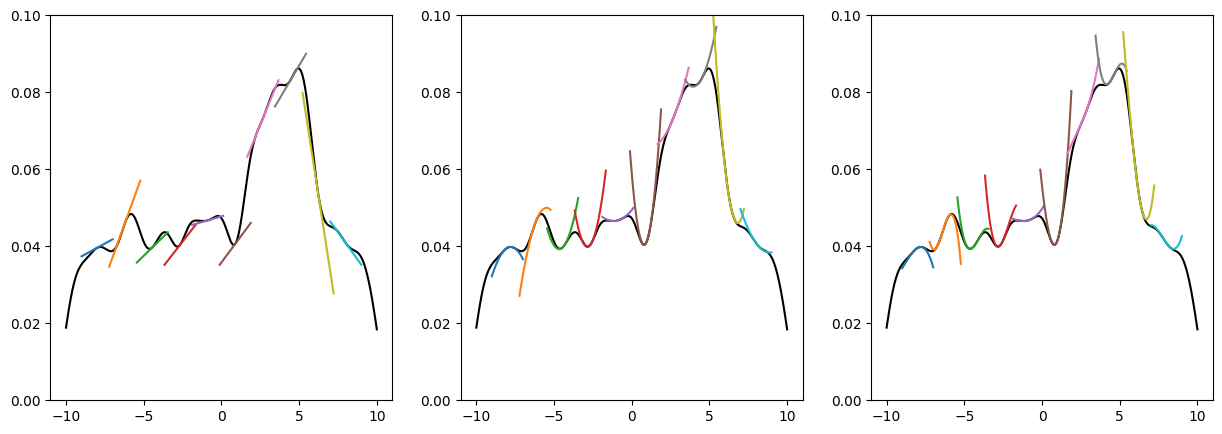

In [ ]:
import jax
import jax.numpy as jnp

samples = jnp.concat(
    (
        jax.random.uniform(
            key=jax.random.PRNGKey(0), shape=(1000,), minval=-10, maxval=10
        ),
        jax.random.normal(key=jax.random.PRNGKey(0), shape=(200,)) * jnp.sqrt(1 / 3 * 6)
        + 4,
    )
)

import matplotlib.pyplot as plt

# plt.hist(samples, bins=50)

# parzen window


@jax.jit
def parzen_window(x: jnp.ndarray, samples: jnp.ndarray, h: float) -> jnp.ndarray:
    return (
        jnp.sum(jax.scipy.stats.norm.pdf((x - samples) / h) / h, axis=0)
        / samples.shape[0]
    )


x = jnp.linspace(-10, 10, 1000)
h = 0.5
func = jax.jit(lambda xs: jax.vmap(lambda x: parzen_window(x, samples, h))(xs))


grad = jax.jit(jax.grad(parzen_window, argnums=0))

taylor_1 = jax.jit(
    lambda p, x: parzen_window(p, samples, h) + grad(p, samples, h) * (x - p)
)

curvature = jax.jit(jax.grad(jax.grad(parzen_window)))

taylor_2 = jax.jit(
    lambda p, x: (
        parzen_window(p, samples, h)
        + grad(p, samples, h) * (x - p)
        + 1 / 2 * curvature(p, samples, h) * (x - p) ** 2
    )
    # * jax.scipy.stats.norm.pdf((p - x) / 2 * h, scale=jnp.sqrt(1 / (2 * jnp.pi)))
)

jerk = jax.jit(jax.grad(jax.grad(jax.grad(parzen_window))))

taylor_3 = jax.jit(
    lambda p, x: (
        parzen_window(p, samples, h)
        + grad(p, samples, h) * (x - p)
        + 1 / 2 * curvature(p, samples, h) * (x - p) ** 2
        + 1 / 6 * jerk(p, samples, h) * (x - p) ** 3
    )
    # * jax.scipy.stats.norm.pdf((p - x) / 2 * h, scale=jnp.sqrt(1 / (2 * jnp.pi)))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

taylors = [taylor_1, taylor_2, taylor_3]

for ax, taylor_func in zip(axs, taylors):
    x = jnp.linspace(-10, 10, 1000)
    y = func(x)
    ax.plot(x, y, label="parzen_window", color="black")
    for point in jnp.linspace(-8, 8, 10):
        x = jnp.linspace(-1 + point, point + 1, 100)
        y = func(x)
        ax.plot(
            x,
            taylor_func(point, x),
        )
    ax.set_ylim(0, 0.1)


def function(x):
    return x**2 + jnp.sin(x)